In [41]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import lightning as L
import neptune.new as neptune
from torchmetrics import Accuracy
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
def norm(data):
    return (data - data.min()) / (data.max() - data.min())

In [115]:
from sklearn.preprocessing import LabelEncoder

train_dir = './train'

path = f'{train_dir}/tdcsfog'
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
tdcsfog_df = pd.concat([pd.read_csv(f).assign(Id=f.split('/')[-1].split('.')[0]) for f in files])
tdcsfog_df.index=range(len(tdcsfog_df))

path = f'{train_dir}/defog'
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
defog_df = pd.concat([pd.read_csv(f).assign(Id=f.split('/')[-1].split('.')[0]) for f in files])
defog_df.index=range(len(defog_df))
# normalize 
defog_df['AccV']=defog_df['AccV']/9.8
defog_df['AccML']=defog_df['AccML']/9.8
defog_df['AccAP']=defog_df['AccAP']/9.8

defog_df['AccV']=norm(defog_df['AccV'])
defog_df['AccML']=norm(defog_df['AccML'])
defog_df['AccAP']=norm(defog_df['AccAP'])

tdcsfog_df['AccV']=norm(tdcsfog_df['AccV'])
tdcsfog_df['AccML']=norm(tdcsfog_df['AccML'])
tdcsfog_df['AccAP']=norm(tdcsfog_df['AccAP'])


df = pd.concat([tdcsfog_df,defog_df])

metadata = pd.read_csv(f'./tdcsfog_metadata.csv')
df = df.merge(metadata, on='Id', how='inner')
encoder = LabelEncoder()
df['Id']=encoder.fit_transform(df['Id'])

In [5]:
defog_df.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,1.352570e+07,1.352570e+07,1.352570e+07,1.352570e+07,1.352570e+07,1.352570e+07,1.352570e+07
mean,8.661159e+04,4.850230e-01,4.730585e-01,5.246817e-01,3.696666e-05,4.201372e-02,6.831512e-03
std,6.479157e+04,8.209921e-03,1.398167e-02,2.970392e-02,6.079909e-03,2.006205e-01,8.237016e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.725600e+04,4.805970e-01,4.656402e-01,5.055496e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.514900e+04,4.837875e-01,4.731997e-01,5.192734e-01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.211790e+05,4.882590e-01,4.820239e-01,5.417080e-01,0.000000e+00,0.000000e+00,0.000000e+00
max,4.153870e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
tdcsfog_df.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06
mean,9.289467e+03,4.645702e-01,4.839436e-01,6.350244e-01,4.315506e-02,2.376979e-01,2.942767e-02
std,1.399893e+04,1.914250e-02,2.366348e-02,2.924302e-02,2.032061e-01,4.256731e-01,1.690020e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.119000e+03,4.564876e-01,4.703685e-01,6.191444e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.310000e+03,4.635564e-01,4.844846e-01,6.373089e-01,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.433000e+03,4.739539e-01,4.984166e-01,6.560114e-01,0.000000e+00,0.000000e+00,0.000000e+00
max,9.707600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
df.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,Visit,Test
count,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06
mean,9.289467e+03,4.645702e-01,4.839436e-01,6.350244e-01,4.315506e-02,2.376979e-01,2.942767e-02,4.291394e+02,7.352151e+00,2.093533e+00
std,1.399893e+04,1.914250e-02,2.366348e-02,2.924302e-02,2.032061e-01,4.256731e-01,1.690020e-01,2.406519e+02,6.779498e+00,8.301861e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00
25%,2.119000e+03,4.564876e-01,4.703685e-01,6.191444e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.190000e+02,2.000000e+00,1.000000e+00
50%,4.310000e+03,4.635564e-01,4.844846e-01,6.373089e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.350000e+02,4.000000e+00,2.000000e+00
75%,8.433000e+03,4.739539e-01,4.984166e-01,6.560114e-01,0.000000e+00,0.000000e+00,0.000000e+00,6.340000e+02,1.300000e+01,3.000000e+00
max,9.707600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.320000e+02,2.000000e+01,3.000000e+00


number of unique participents:

In [18]:
len(df['Subject'].unique())

62

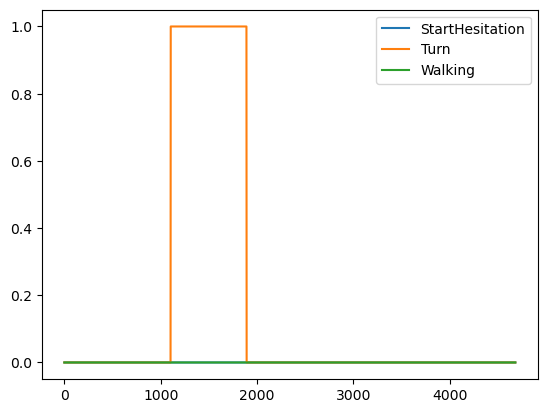

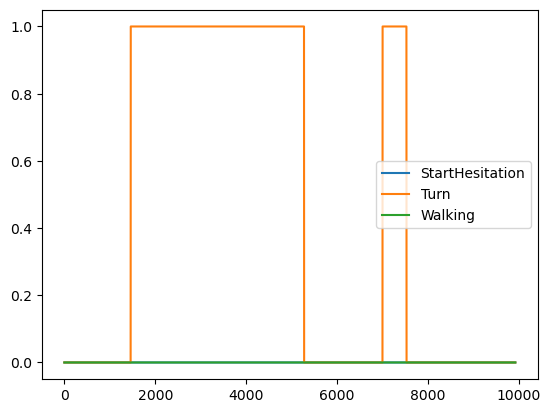

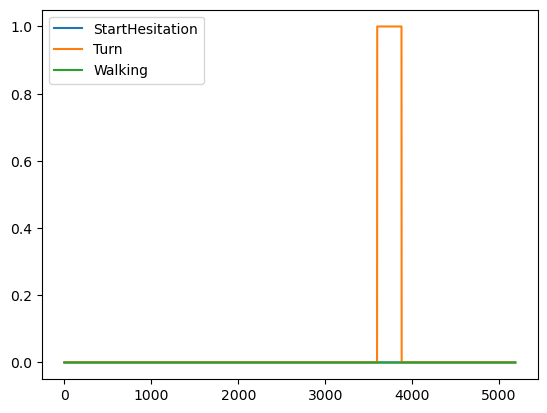

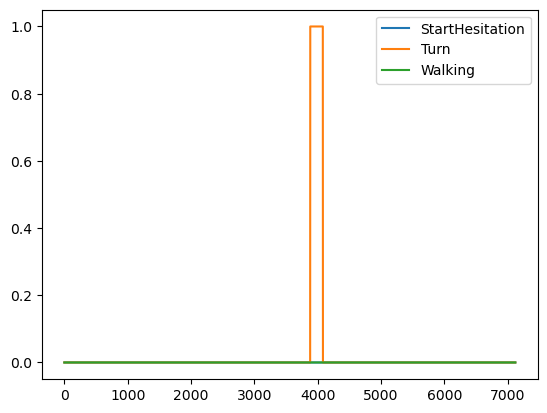

In [8]:
for i in range(4):
    plt_df=df[df['Id'] == i]
    plt.plot(range(len(plt_df)),list(plt_df['StartHesitation']),label='StartHesitation')
    plt.plot(range(len(plt_df)),list(plt_df['Turn']),label='Turn')
    plt.plot(range(len(plt_df)),list(plt_df['Walking']),label='Walking')
    plt.legend()
    plt.show()

In [181]:
def get_rows_with_lables(df):
    any_ones = df[['StartHesitation', 'Turn', 'Walking']].eq(1).any(axis=1)
    idx_with_ones = df[any_ones].index
    return idx_with_ones

def wind(df, window):
    lable_indexes = list(get_idx_of_lables(df))
    times = np.array(df['Time'])

    lable_indexes = np.array(lable_indexes)
    mask = np.where(lable_indexes[1:] - lable_indexes[:-1] != 1)[0]

    start_segments = lable_indexes[np.concatenate((np.array([0]), mask + 1))]
    end_segments = lable_indexes[np.concatenate((mask, np.array([len(lable_indexes) - 1])))]

    res = []

    for start, end in zip(start_segments, end_segments):
        res.extend(times[max(0, start - window // 2):start])
        res.extend(lable_indexes[start:end+1])
        res.extend(times[end:min(len(times)-1, end + window // 4)])

    return res

def window(df, window_size):
    win_has_label_idx = wind(df, window_size)
    return df.iloc[win_has_label_idx]

windowed_df = pd.concat([window(tdcsfog_df,256),window(defog_df,200)])



,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,Valid,Task
975,975,0.488417,0.520444,0.651868,0,0,0,003f117e14,NaN,NaN
976,976,0.483913,0.519897,0.648895,0,0,0,003f117e14,NaN,NaN
977,977,0.481056,0.517381,0.646431,0,0,0,003f117e14,NaN,NaN
978,978,0.476980,0.512631,0.647596,0,0,0,003f117e14,NaN,NaN
979,979,0.472583,0.507927,0.649628,0,0,0,003f117e14,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
118170,118170,0.480806,0.476563,0.505550,0,0,0,02ea782681,False,False
118171,118171,0.480806,0.474775,0.503936,0,0,0,02ea782681,False,False
118172,118172,0.480806,0.474742,0.503906,0,0,0,02ea782681,False,False
118173,118173,0.480806,0.476483,0.503906,0,0,0,02ea782681,False,False


# data distribution plots

In [85]:
def get_top_k_subjects(df,event,k):
    grouped_by_id = df.groupby('Id')[event].sum()
    return grouped_by_id.nlargest(k).index
    

## Features

In [ ]:
def plot_value_top_k(event,k):
    for i in get_top_k_subjects(df,event,k):
        plt.title(f'subject_{i}')
        user_entries=df[df['Id']==i]
        idx = [x for x in agg_has_label_idx if x<=len(user_entries)]
        for col in ['AccV','AccML','AccAP']:
            plt.plot(idx,list(user_entries.iloc[idx][col]),label=col)
        plt.legend()
        plt.show()

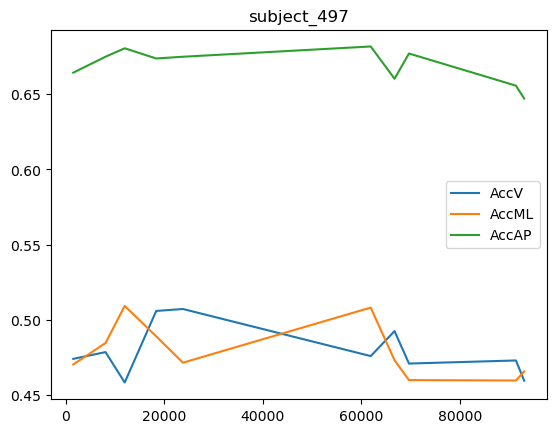

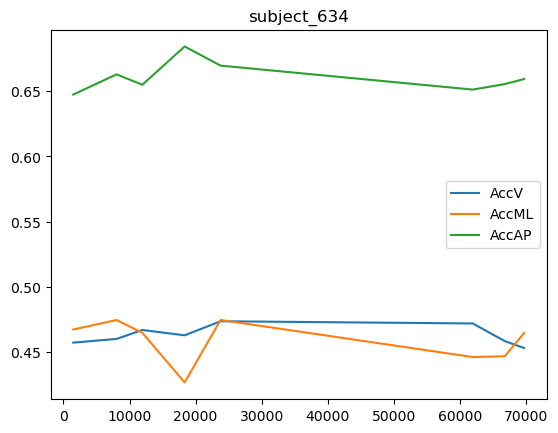

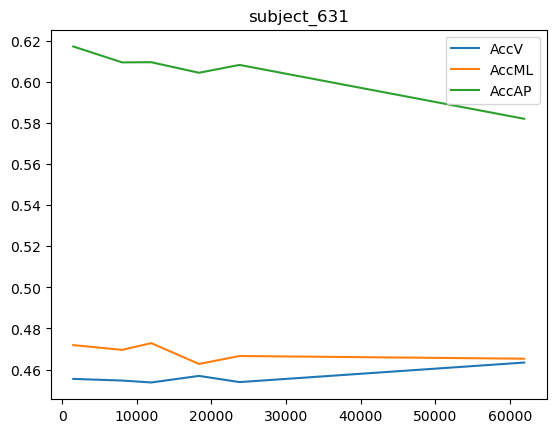

In [112]:
k=3
plot_value_top_k('Turn',k)

## Targets

In [114]:
def plot_event_top_k(event,k):
    plt.title(event)
    df=defog_df
    for i in get_top_k_subjects(df,event,k):
        user_entries=df[df['Id']==i]
        idx = [x for x in agg_has_label_idx if x<=len(user_entries)]
        plt.step(idx,list(user_entries.iloc[idx][event]),label=f'subject_{i}')
    # plt.legend()
    plt.show()

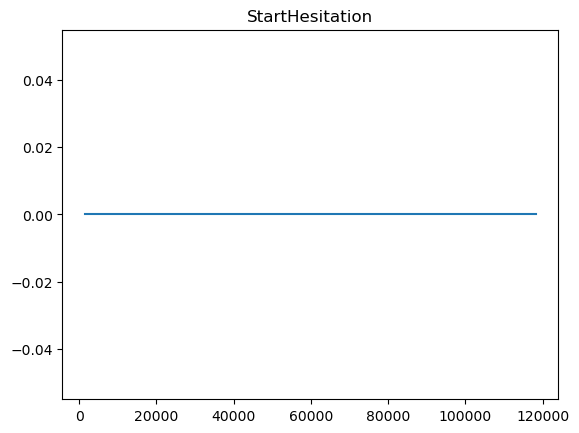

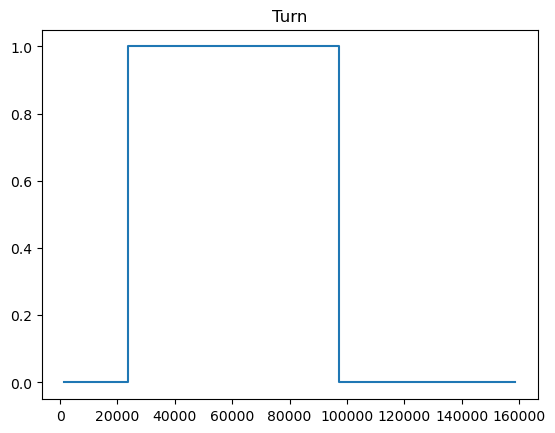

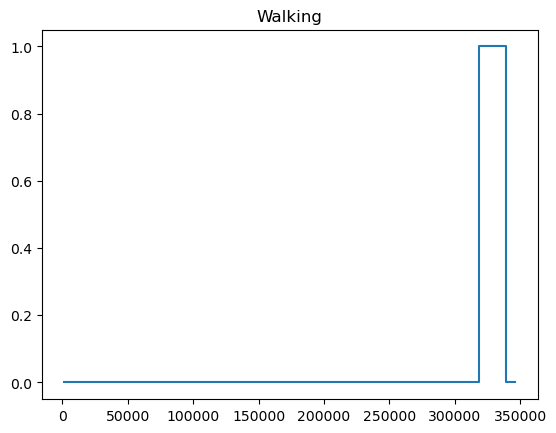

In [117]:
k=1
plot_event_top_k('StartHesitation',k)
plot_event_top_k('Turn',k)
plot_event_top_k('Walking',k)

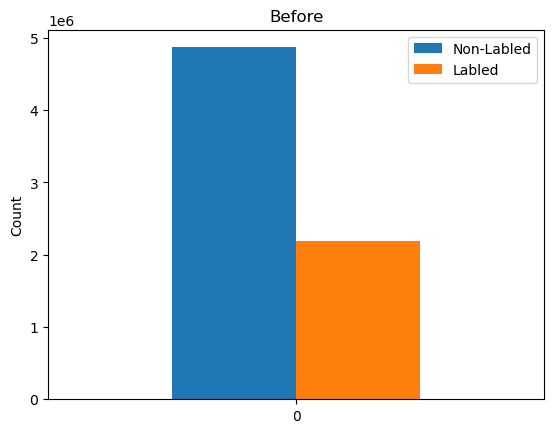

0.31028058502504435


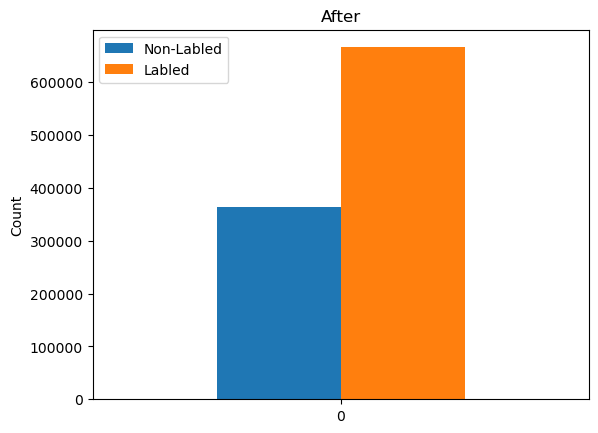

0.6466138605011761


In [187]:
def plot_lbl_count(df,title):
    lbl_count = len(get_idx_of_lables(df))
    non_lbl_count = len(df) - lbl_count

    # Combine the counts into a single DataFrame
    counts = pd.DataFrame({'Non-Labled': [non_lbl_count],'Labled': [lbl_count]})

    # Create a bar plot
    counts.plot(kind='bar')

    # Customize the plot
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=0)

    # Display the plot
    plt.show()
    z=zeros_count.sum()
    o=df[['StartHesitation', 'Turn', 'Walking']].sum().sum()
    print(lbl_count/len(df))
plot_lbl_count(df,'Before')
plot_lbl_count(windowed_df,'After')

# correlation

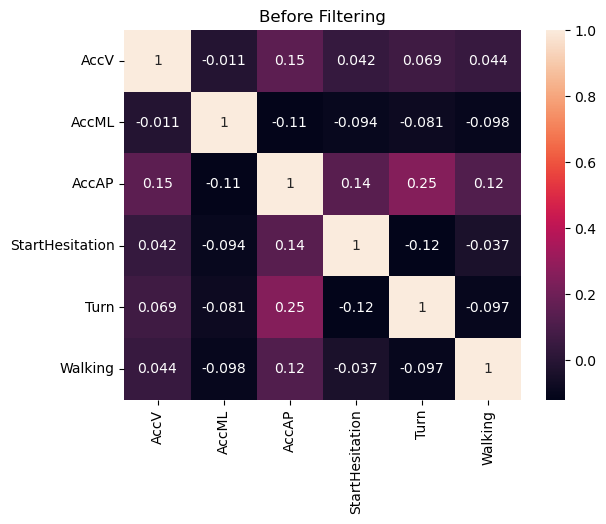

In [184]:
correlation_matrix =df[['AccV','AccML','AccAP','StartHesitation', 'Turn', 'Walking']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Before Filtering')
plt.show()

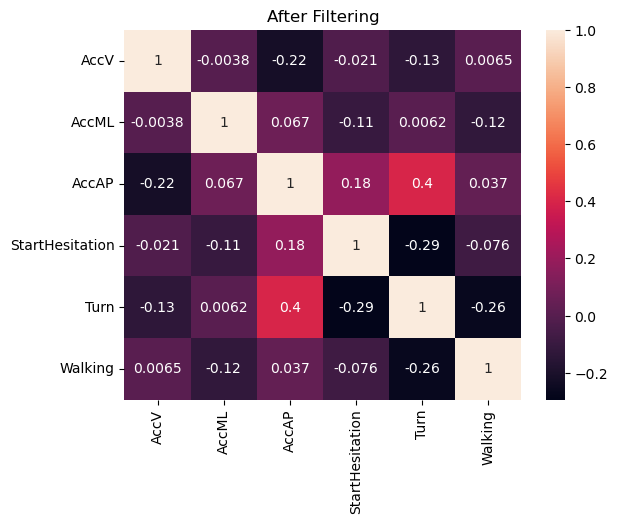

In [185]:
correlation_matrix =windowed_df[['AccV','AccML','AccAP','StartHesitation', 'Turn', 'Walking']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('After Filtering')
plt.show()

In [11]:
from sklearn.feature_selection import SelectKBest, chi2

X = df[['AccV','AccML','AccAP']]
y_start_hesitation = df['StartHesitation']
y_turn = df['Turn']
y_walking = df['Walking']

# Apply the chi-squared test to select the k most important features
selector = SelectKBest(chi2, k=2)
selector.fit(X, y_start_hesitation)
print('Most important features for StartHesitation:', X.columns[selector.get_support()])

selector.fit(X, y_turn)
print('Most important features for Turn:', X.columns[selector.get_support()])

selector.fit(X, y_walking)
print('Most important features for Walking:', X.columns[selector.get_support()])

Most important features for StartHesitation: Index(['AccML', 'AccAP'], dtype='object')
Most important features for Turn: Index(['AccML', 'AccAP'], dtype='object')
Most important features for Walking: Index(['AccML', 'AccAP'], dtype='object')
